# Analytics Practicum - Group 1
## Billing/Invoice Clustering - ZMS

## <font color=blue>Import needed modules</font>

In [29]:
#general libraries always needed
import pandas as pd
import numpy as np
import math

#plotting required modules
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FixedLocator, FixedFormatter

#sklearn clustering / unsupervised learning modules
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors


#sklearn modules for preprocessing and transformation
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

ModuleNotFoundError: No module named 'google.colab'

In [3]:
pd. set_option('display.max_columns', None) # or 1000.
pd. set_option('display.max_rows', None) # or 1000.
pd. set_option('display.max_colwidth', -1) # or 199

<ipython-input-3-b68f7aae5278>:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd. set_option('display.max_colwidth', -1) # or 199


## <font color=blue>Function Definitions</font>

In [4]:
#function to create an Avg. Distance to Nearest Neighbor plt
def nn_avg_distance(X):
    plt.figure(figsize=(10,5))
    nn = NearestNeighbors(n_neighbors=15).fit(X)
    distances, idx = nn.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)
    plt.xlabel("Instances", fontsize=14)
    plt.ylabel("Distances", fontsize=14)
    plt.title("Average Distance to Nearset Neighbor")
    plt.show()

In [5]:
#function to create a silhouette diagram
#requires the model, the independent value (i.e. X) used to fit the model, and a list of k values to plot

def inertia_silhouette_plot( X, k_values): 

    #iterate through different k values and collect inertia values and silhouette scores
    kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, max(k_values)+1)]
    inertias = [model.inertia_ for model in kmeans_per_k]
    silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]    
    
    #print the silhouette scores and k values
    plt.plot(inertias)
    plt.ylabel("Inertia", fontsize=14)
    plt.xlabel("k Value", fontsize=14)
    plt.show()
    print("-"*80)
    #create the plot's figure
    plt.figure(figsize=(10, len(k_values)*3))

    ct = 0 #temp counter variable

    #build a subplot for each value of k
    for k in k_values:
    
        #create the subplot
        ct +=1
        plt.subplot(math.ceil(len(k_values)/2), 2, ct)
    
        #get the predictions and silhouette value
        y_pred = kmeans_per_k[k - 1].labels_
        silhouette_coefficients = silhouette_samples(X, y_pred)

        #create the bars for each cluster
        padding = X.shape[0] // 30
        pos = padding
        ticks = []
        for i in range(k):
            coeffs = silhouette_coefficients[y_pred == i]
            coeffs.sort()

            color = mpl.cm.Spectral(i / k)
            plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
            ticks.append(pos + len(coeffs) // 2)
            pos += len(coeffs) + padding

        plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
        plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))

       #plot the silhouette line
        plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
        
        #chart title
        plt.title("k={} --- {:.2}".format(k, silhouette_scores[k - 2]), fontsize=16)
 
        #add a y label for each row and an x axis label for the last 2 graphs
        if ct%2 == 1:
            plt.ylabel("Cluster")
        if ct == len(k_values) or ct==len(k_values)-1:
            #plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
            plt.xlabel("Silhouette Coefficient")
                
    #plot
    plt.show()

In [6]:
#function to create a 2 dimmensional representation of data using tSNE
#needs the independent data as well as Y label data OR prediction
def tsne_plot(X, y):
    X_tsne = TSNE(learning_rate=1000, perplexity=25, init="random").fit_transform(X)
    plt.figure(1, facecolor='white', figsize=(10, 12))
    a=plt.scatter(
        X_tsne[(y!=-1), 0],
        X_tsne[(y!=-1), 1],
        s=100,
        alpha=0.90,
        c=y[y!=-1],
        cmap=cm.Paired
    )
    plt.legend(handles=a.legend_elements()[0],labels=a.legend_elements()[1])
    plt.scatter(
        X_tsne[(y==-1), 0],
        X_tsne[(y==-1), 1],
        s=100,
        alpha=0.05
    )
    plt.title('T-SNE Plot')
    plt.show()

In [7]:
#function to verify the existence of a file in the current working directory and download it if not
import os,urllib, urllib.request, sys, tarfile
def downloadDataResource(file,sourcePath,compressed=None):
    if not os.path.isfile(file):
        try:
            urllib.request.urlretrieve(sourcePath+(compressed if compressed else file),(compressed if compressed else file))
            print("Downloaded", (compressed if compressed else file) )
            if compressed:
                ucomp = tarfile.open(compressed)
                ucomp.extractall()
                ucomp.close()
                print("File uncompressed.")
        except:
            print("ERROR: File", (compressed if compressed else file), "not found. Data source missing.")
    else:
        print("Data resource", file, "already downloaded.")## <font color=blue>Source data</font>

## <font color=blue>Source Data</font>

In [8]:
#download data files if not currently downloaded into the current working directory
filename = ["BilingandIncome_Dataset.csv"]
    
#read files
bill = pd.read_csv(filename[0])

In [9]:
bill = bill.fillna(0)
bill.head()

,ACCT_MASKED,Avg_Q1_2021,Avg_Q2_2021,Avg_Q3_2021,Avg_Q4_,Avg_Q4_2021,Min_Q1_2021,Min_Q2_2021,Min_Q3_2021,Min_Q4_2021,Max_Q1_2021,Max_Q2_2021,Max_Q3_2021,Max_Q4_2021,NumofPaymentType,income_code_desc,investments_personal,investments_real_estate,investments_stocks_bonds,education_online,reading_financial_newsletter_subscribers,income_estimated_household_desc,networth_gold_desc
0,10984576964,256.441026,100.014068,153.368202,0.0,138.624286,237.16,28.03,47.11,44.11,267.54,142.00,241.21,174.79,2,"$90,000 - $99,999",NO,NO,NO,NO,YES,"$75,000 - $99,999","$100,000 - $249,999"
1,10984578517,67.907245,55.832500,126.113488,0.0,91.895000,64.30,47.16,104.18,54.27,71.55,65.13,147.08,119.92,1,"$15,000 - $19,999",YES,NO,YES,NO,YES,"$15,000 - $19,999","$100,000 - $249,999"
2,10984578653,129.861591,89.104146,150.985000,0.0,78.846667,109.58,78.49,126.62,77.70,146.15,105.99,160.92,79.42,1,"$70,000 - $79,999",NO,NO,NO,YES,NO,"$50,000 - $74,999","$10,000 - $24,999"
3,10984578655,117.049300,85.554189,78.175217,0.0,71.726667,86.83,64.96,66.55,62.95,178.18,118.81,88.07,76.80,1,"$15,000 - $19,999",YES,NO,YES,YES,NO,"$15,000 - $19,999","$100,000 - $249,999"
4,10984579469,108.000000,172.000000,172.000000,0.0,725.000000,108.00,172.00,172.00,725.00,108.00,172.00,172.00,725.00,1,"$40,000 - $49,999",YES,YES,YES,YES,NO,0,"Greater than $1,999,999"


## <font color=blue>Prepare Data</font>

In [10]:
#drop columns
accts = bill['ACCT_MASKED']
bill = bill.replace("NO", 0)
bill = bill.replace("YES", 1)
bill.drop(columns=['ACCT_MASKED', 'education_online', 'reading_financial_newsletter_subscribers', 'income_estimated_household_desc'], inplace=True)

bill['income_code_desc'] = bill['income_code_desc'].replace(0, "Not Available")
bill['networth_gold_desc'] = bill['networth_gold_desc'].replace(0, "Not Available")

data = bill.copy()

### Build Transformation Pipeline

In [11]:
#no categorical attributes for this data set (nice to have in case data changes)
cat_attribs = ['income_code_desc','networth_gold_desc' ]

#set the numerical attributes
num_attribs = list(data.drop(columns=cat_attribs))


#Pipeline that does nothing
no_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

#define pipeline for numeric attributes (this code is just a definition)
#each numeric attribute will be imputated using the Median strategy
#each numeric attribute will be scaled 
num_pipeline = Pipeline( [
 ('imputer', SimpleImputer(strategy="median")), #because no missing values, not used
# ('log', PowerTransformer(method = 'box-cox')), 
 ('std_scaler', StandardScaler()),   
])

#define the pipeline process for the data set
full_pipeline = ColumnTransformer( [
    ('cat', OneHotEncoder(), cat_attribs),
    ('num', num_pipeline, num_attribs)
])

# Create X data set

In [12]:
X = full_pipeline.fit_transform( data )
X.shape

(5000, 43)

## <font color=blue>Training a K-Means Clustering Model


## <font color=red>How many clusters?

### Use inertia plot to determine how many ks to use in the model

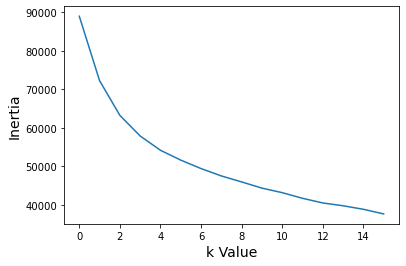

--------------------------------------------------------------------------------


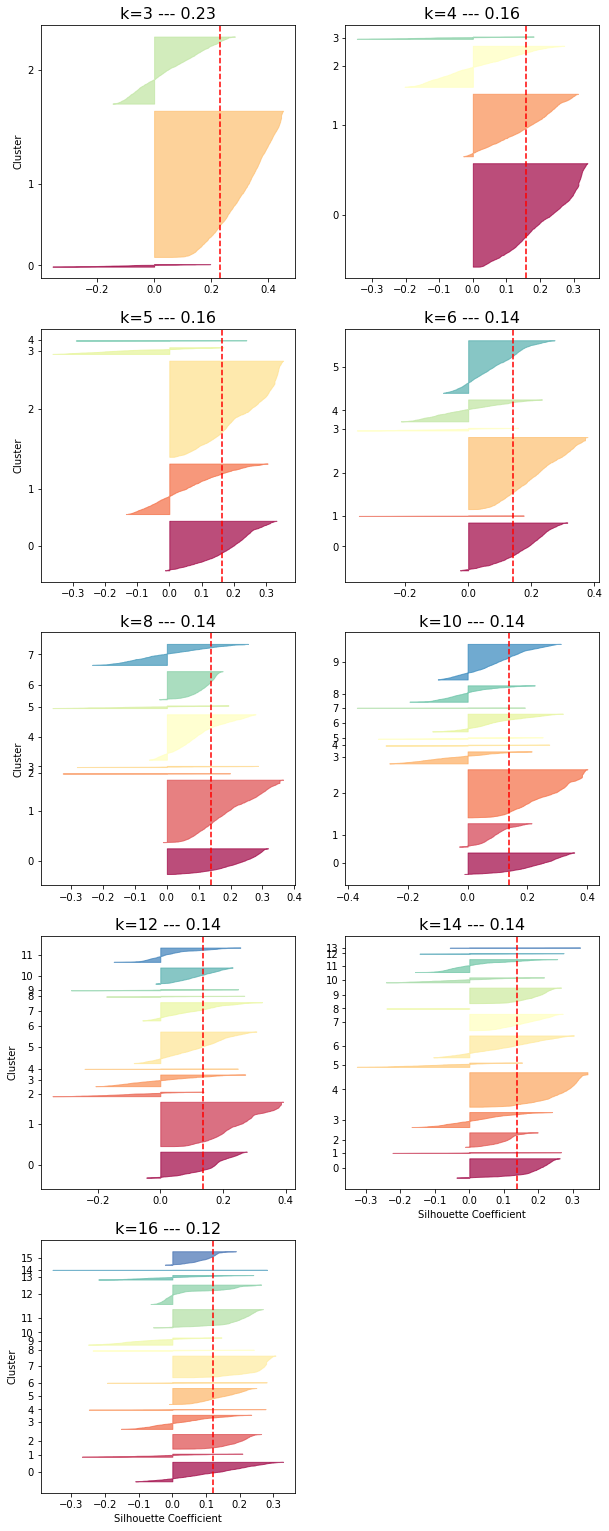

In [13]:
#use function to evaluate X data across different k values
inertia_silhouette_plot(X, [3, 4, 5, 6, 8, 10, 12, 14, 16])

### looking for the elbow of the model in the first graph and then equally sized shapes for the second graph. 
### k = 4 seems to be the most resonable way to cluster the data while taking into account the business needs

In [14]:
k = 4

#create the model
kmeans = KMeans(n_clusters=k, random_state=42)

#fit the model and predict y values (i.e. cluster value)
y_pred = kmeans.fit_predict(X)

Each instance was assigned to one of the k clusters

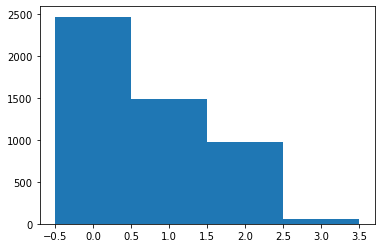

In [15]:
#plot the number of instances in each of the created clusters
plt.hist(y_pred, bins=range(k+1), align='left')
plt.show()

In [16]:
#save the predictions of each instance to a column called KMeans
data[ "KMeans"] = y_pred

In [17]:
data['KMeans'].value_counts()

0    2472
1    1493
2    980 
3    55  
Name: KMeans, dtype: int64

In [18]:
#explore some of the clusters
data[ data.KMeans == 0].describe()


,Avg_Q1_2021,Avg_Q2_2021,Avg_Q3_2021,Avg_Q4_,Avg_Q4_2021,Min_Q1_2021,Min_Q2_2021,Min_Q3_2021,Min_Q4_2021,Max_Q1_2021,Max_Q2_2021,Max_Q3_2021,Max_Q4_2021,NumofPaymentType,investments_personal,investments_real_estate,investments_stocks_bonds,KMeans
count,2472.000000,2472.000000,2472.000000,2472.0,2472.000000,2472.000000,2472.000000,2472.000000,2472.000000,2472.000000,2472.000000,2472.000000,2472.000000,2472.000000,2472.000000,2472.000000,2472.000000,2472.0
mean,116.314128,90.152035,106.776183,0.0,94.667397,89.575914,62.823815,77.147516,62.984082,145.166748,123.856173,143.450918,132.114175,1.654935,0.179612,0.125000,0.030744,0.0
std,78.798446,59.127871,66.800277,0.0,63.366360,73.705930,48.365709,60.198586,49.952054,108.524275,109.454729,123.797713,106.280689,0.867755,0.383941,0.330786,0.172659,0.0
min,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0
25%,57.202446,47.758732,58.317544,0.0,51.581445,34.150000,26.600000,25.322500,24.972500,69.542500,60.067500,75.410000,67.215000,1.000000,0.000000,0.000000,0.000000,0.0
50%,100.602731,79.864932,98.641012,0.0,84.928750,73.520000,56.000000,72.020000,56.390000,123.595000,102.235000,122.125000,114.190000,1.000000,0.000000,0.000000,0.000000,0.0
75%,164.091809,123.889606,145.876222,0.0,127.780652,135.037500,93.000000,116.725000,91.162500,200.000000,157.290000,185.665000,171.332500,2.000000,0.000000,0.000000,0.000000,0.0
max,507.570000,534.910280,639.461386,0.0,648.272841,507.570000,400.980000,471.490000,381.920000,1278.190000,1248.910000,2028.330000,1160.000000,6.000000,1.000000,1.000000,1.000000,0.0


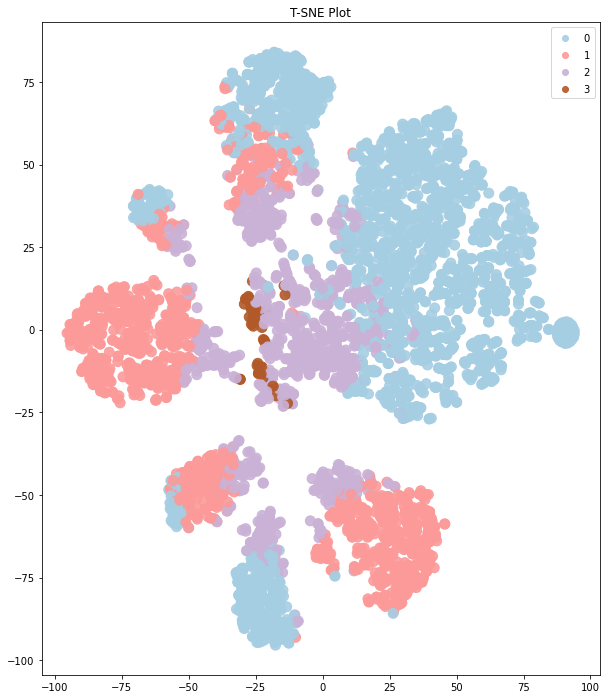

In [19]:
#plot K means results on a 2-dimensional tSNE of the same data set
tsne_plot(X, y_pred)

## Export data as a csv

In [30]:
billing_income_result = data
billing_income_acct = accts
method = 'KMeans'
name = 'billing_income_output'
cluster = billing_income_result[method]
output = pd.concat([billing_income_acct, cluster], axis=1)
output.to_excel(name+".xlsx")  